In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio as rio
from rasterio import features
from pathlib import Path
import pathlib
import geopandas as gpd
from descartes import PolygonPatch
from PIL import Image
import itertools
import re
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import imgaug
import random
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

%matplotlib inline

def set_seed(seed=0):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    #imgaug.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [2]:
# Load split over training data
train_dir = Path('../../DATASET/dataset_pruebas/train')
test_dir = Path('../../DATASET/dataset_pruebas/validation')
sample_dir = Path('../../DATASET/SN7_buildings_train_sample')

root_dir  = train_dir
csv_file = Path('../output_csvs/df_train_untidy.csv')
df = pd.read_csv(csv_file)

In [3]:
csv_file

PosixPath('../output_csvs/df_train_untidy.csv')

In [4]:
class Dataloader_trdp(Dataset):
    """SpaceNet 7 Multi-Temporal Satellite Imagery Dataset"""
    
    def __init__(self,csv_file, root_dir, no_udm=True, transform=None, chip_dimension=None):
        """
        Args:
            csv_file (Path): Path to the csv file with annotations
            root_dir (Path): Parent directory containing all other directories.
            no_udm (bool): Specifies whether the dataset will load UDM images or not.
            transform (callable, optional): Optional transform to be applied on a sample.
            chip_dimension (int, optional): Specifies the dimensions of the chip being generated.
        """
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.no_udm = no_udm
        self.transform = transform
        self.idx_combinations = self.total_number_of_images()
        self.chip_dimension = chip_dimension
        if self.chip_dimension is not None:
            self.chip_generator = self.__ChipGenerator(chip_dimension = self.chip_dimension)
            # this will be replaced later with an abstracted version
            # returns number of chips per image assuming all images are 1024
            self.n_chips = ((1024 - 1) // self.chip_dimension + 1)**2
            
    def __len__(self):
        if self.chip_dimension is not None: # Total # images = No clouds + Not none
            return len(self.idx_combinations)*self.n_chips
        else:
            return len(self.idx_combinations)
    
    def __getitem__(self,idx):
        if self.chip_dimension is not None:
            raster_idx = idx//self.n_chips
            chip_idx = idx%self.n_chips
        else:
            raster_idx = idx
            
        if torch.is_tensor(raster_idx):
            raster_idx = raster_idx.tolist()
        # get the indices of the 2 images
        idx1 = self.idx_combinations[raster_idx]
        # paths where the images are stored
        img1_path = self.root_dir/self.annotations.loc[idx1,'images_masked']
        # paths where the corresponding true building footprints 
        labels1_path = self.root_dir/self.annotations.loc[idx1,'labels_match_pix']
        # read rasters using imported rasterio library
        with rio.open(img1_path) as r1:
            raster1 = r1.read()[0:3]  
        # get the concatenated array of the 2 images that will be fed into the neural_net
        raster_diff = raster1 #np.concatenate((raster1,raster2),axis=0)
        # get the dates for the images
        date1 = tuple(self.annotations.loc[idx1,['month','year']])
        
        
        #date2 = tuple(self.annotations.loc[idx2,['month','year']])
        # read geojson files for each of the satellite images into a geodataframe
        gdf1 = gpd.read_file(labels1_path).set_index('Id').sort_index()
        #gdf2 = gpd.read_file(labels2_path).set_index('Id').sort_index()
        # get the change between the 2 satellite images by comparing their polygons
        gdf_diff = gdf1  # self.__geo_difference(labels1_path,labels2_path)
        # get the corresponding rasterized image of the geodataframes
        mask_diff = self.__rasterize_gdf(gdf_diff,out_shape=raster1.shape[1:3])
        
        if self.chip_dimension:
            raster_diff_dict = self.chip_generator(raster_diff)
            mask_diff_dict = self.chip_generator(mask_diff)

            sample = {'raster_diff':raster_diff_dict['chip'][chip_idx],'date1':date1,
          'mask_diff':mask_diff_dict['chip'][chip_idx],'im_dir':str(img1_path.parent.parent),'blank_label':mask_diff_dict['blank'][chip_idx], 
                     }
        
        else:
            sample = {'raster_diff':raster_diff,'date1':date1, 'mask_diff':mask_diff,'im_dir':str(img1_path.parent.parent)}
        
        if self.transform is not None:
            # get the individual images and mask from the output sample
            raster1 = np.moveaxis(np.uint8(sample['raster_diff'][:3]),0,-1)
            #raster2 = np.moveaxis(np.uint8(sample['raster_diff'][3:6]),0,-1)
            mask = np.moveaxis(np.uint8(sample['mask_diff']),0,-1)
            import random
            seed = random.randint(0,1000)
            set_seed(seed)
            
            # apply transform on first image and mask
            transformed = self.transform(image=raster1,mask=mask)
            raster1 = transformed['image']
            mask_diff = transformed['mask']
            
            set_seed(seed)
            
            # apply transform on second image
            #raster2 = self.transform(image=raster2)['image']
            # concatenate input images
            raster_diff = raster1
            # update sample dictionary paramters after transformation
            if not isinstance(raster_diff,np.ndarray):
                sample['raster_diff'] = raster_diff
                mask_diff = mask_diff.permute(2,0,1)
                sample['mask_diff'] = mask_diff
            else:
                sample['raster_diff'] = raster_diff
                mask_diff = np.moveaxis(mask_diff,-1,0)
                sample['mask_diff'] = mask_diff
            
        return sample
    
    def total_number_of_images(self):
            # we need to change it to obtain all the possible images we are going to use
            total_images = []
            # group by satellite image location
            location_groups = self.annotations.groupby('images')
            for i,location in enumerate(location_groups):
                # get the dataframe in the group
                loc_frame = location[1]
                # make sure that list does not contain images with unidentified masks
                condition = (loc_frame['has_udm'] == False)
                # return a list of the indices in the location dataframe
                l = list(loc_frame[condition].index)
                total_images.extend(l)
            return total_images 
    

    
    def __rasterize_gdf(self,gdf,out_shape):
        # if geodataframe is empty return empty mask
        if len(gdf)==0:
            return np.zeros((1,*out_shape))
            
        mask = features.rasterize(((polygon, 255) for polygon in gdf['geometry']),out_shape=out_shape)
        
        return np.expand_dims(mask,axis=0)
    
    class __ChipGenerator():   
        def __init__(self, chip_dimension=256,return_raster=False):  
            self.chip_dimension = chip_dimension
            self.return_raster = return_raster
            self.chip_dict = {'chip':[],'x':[],'y':[], 'blank':[]}

        def __call__(self,raster):
            np_array = self.__read_raster(raster)
            # get number of chips per colomn
            n_rows = (np_array.shape[1] - 1) // self.chip_dimension + 1
            # get number of chips per row
            n_cols = (np_array.shape[2] - 1) // self.chip_dimension + 1
            # segment image into chips and return dict of chips and metadata
            chip_dict = {'chip':[],'x':[],'y':[], 'blank':[]}

            for r in range(n_rows):
                for c in range(n_cols):
                    start_r_idx = r*self.chip_dimension
                    end_r_idx = start_r_idx + self.chip_dimension

                    start_c_idx = c*self.chip_dimension
                    end_c_idx = start_c_idx + self.chip_dimension
                    
                    chip = np_array[:,start_r_idx:end_r_idx,start_c_idx:end_c_idx]

                    chip_dict['chip'].append(chip)
                    chip_dict['x'].append(start_r_idx)
                    chip_dict['y'].append(start_c_idx)
                    
                    # Check if the chip is an empty chip
                    if chip.mean() == 0 and chip.sum() == 0:
                        chip_dict['blank'].append(1)
                    else:
                        chip_dict['blank'].append(0)

            return chip_dict

        def __read_raster(self,raster):
            # check whether raster is a path or array
            if isinstance(raster,(pathlib.PurePath,str)):
                    with rio.open(raster) as r:
                        # convert raster into np array
                        np_array = r.read()
                    return np_array

            elif isinstance(raster,np.ndarray):
                return raster
            else:
                raise ValueError(f"Expected Path or Numpy array received: {type(raster)}")  

In [5]:
train_set = Dataloader_trdp(root_dir=root_dir,csv_file=csv_file,chip_dimension=1024)

In [6]:
print(f"combinations: {len(train_set.idx_combinations)}")
print(f"n_chips per image: {train_set.n_chips}")
print(f"length dataset: {len(train_set)}, which is equivalent to (# combinations x patch_size): {len(train_set.idx_combinations) * train_set.n_chips} ")

combinations: 94
n_chips per image: 1
length dataset: 94, which is equivalent to (# combinations x patch_size): 94 


In [7]:
train_set.n_chips
train_set.annotations


,parent_dir,image_dir_name,fname,year,month,has_udm,udm_masks,images,images_masked,labels_buildings,labels_udm,labels_match,labels_match_pix
0,train,L15-0357E-1223N_1429_3296_13,global_monthly_2018_01_mosaic_L15-0357E-1223N_...,2018,1,False,NaN,L15-0357E-1223N_1429_3296_13/images/global_mon...,L15-0357E-1223N_1429_3296_13/images_masked/glo...,L15-0357E-1223N_1429_3296_13/labels/global_mon...,L15-0357E-1223N_1429_3296_13/labels/global_mon...,L15-0357E-1223N_1429_3296_13/labels_match/glob...,L15-0357E-1223N_1429_3296_13/labels_match_pix/...
1,train,L15-0357E-1223N_1429_3296_13,global_monthly_2018_02_mosaic_L15-0357E-1223N_...,2018,2,False,NaN,L15-0357E-1223N_1429_3296_13/images/global_mon...,L15-0357E-1223N_1429_3296_13/images_masked/glo...,L15-0357E-1223N_1429_3296_13/labels/global_mon...,L15-0357E-1223N_1429_3296_13/labels/global_mon...,L15-0357E-1223N_1429_3296_13/labels_match/glob...,L15-0357E-1223N_1429_3296_13/labels_match_pix/...
2,train,L15-0357E-1223N_1429_3296_13,global_monthly_2018_03_mosaic_L15-0357E-1223N_...,2018,3,False,NaN,L15-0357E-1223N_1429_3296_13/images/global_mon...,L15-0357E-1223N_1429_3296_13/images_masked/glo...,L15-0357E-1223N_1429_3296_13/labels/global_mon...,L15-0357E-1223N_1429_3296_13/labels/global_mon...,L15-0357E-1223N_1429_3296_13/labels_match/glob...,L15-0357E-1223N_1429_3296_13/labels_match_pix/...
3,train,L15-0357E-1223N_1429_3296_13,global_monthly_2018_04_mosaic_L15-0357E-1223N_...,2018,4,False,NaN,L15-0357E-1223N_1429_3296_13/images/global_mon...,L15-0357E-1223N_1429_3296_13/images_masked/glo...,L15-0357E-1223N_1429_3296_13/labels/global_mon...,L15-0357E-1223N_1429_3296_13/labels/global_mon...,L15-0357E-1223N_1429_3296_13/labels_match/glob...,L15-0357E-1223N_1429_3296_13/labels_match_pix/...
4,train,L15-0357E-1223N_1429_3296_13,global_monthly_2018_05_mosaic_L15-0357E-1223N_...,2018,5,False,NaN,L15-0357E-1223N_1429_3296_13/images/global_mon...,L15-0357E-1223N_1429_3296_13/images_masked/glo...,L15-0357E-1223N_1429_3296_13/labels/global_mon...,L15-0357E-1223N_1429_3296_13/labels/global_mon...,L15-0357E-1223N_1429_3296_13/labels_match/glob...,L15-0357E-1223N_1429_3296_13/labels_match_pix/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,train,L15-0368E-1245N_1474_3210_13,global_monthly_2019_09_mosaic_L15-0368E-1245N_...,2019,9,False,NaN,L15-0368E-1245N_1474_3210_13/images/global_mon...,L15-0368E-1245N_1474_3210_13/images_masked/glo...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels_match/glob...,L15-0368E-1245N_1474_3210_13/labels_match_pix/...
93,train,L15-0368E-1245N_1474_3210_13,global_monthly_2019_10_mosaic_L15-0368E-1245N_...,2019,10,False,NaN,L15-0368E-1245N_1474_3210_13/images/global_mon...,L15-0368E-1245N_1474_3210_13/images_masked/glo...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels_match/glob...,L15-0368E-1245N_1474_3210_13/labels_match_pix/...
94,train,L15-0368E-1245N_1474_3210_13,global_monthly_2019_11_mosaic_L15-0368E-1245N_...,2019,11,False,NaN,L15-0368E-1245N_1474_3210_13/images/global_mon...,L15-0368E-1245N_1474_3210_13/images_masked/glo...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels_match/glob...,L15-0368E-1245N_1474_3210_13/labels_match_pix/...
95,train,L15-0368E-1245N_1474_3210_13,global_monthly_2019_12_mosaic_L15-0368E-1245N_...,2019,12,False,NaN,L15-0368E-1245N_1474_3210_13/images/global_mon...,L15-0368E-1245N_1474_3210_13/images_masked/glo...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels/global_mon...,L15-0368E-1245N_1474_3210_13/labels_match/glob...,L15-0368E-1245N_1474_3210_13/labels_match_pix/...


In [8]:
for i in range(len(train_set)):
    sample = train_set[i]
    # verify dimensionality
    print(sample['raster_diff'].shape, sample['mask_diff'].shape)
    if i==15:

        break

(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)


# Download all images

In [32]:
import matplotlib.pyplot as plt
import matplotlib
'''
for i in range(len(train_set)):
    sample = train_set[i]
    # verify dimensionality
    print(sample['raster_diff'].shape, sample['mask_diff'].shape)
    if i==15:
        break
'''      

for i in range(len(train_set)):
    
    sample = train_set[i]
    mask = sample["mask_diff"]
    #mask = Image.fromarray(mask)
    
    fname  = train_set.annotations.fname[i]
    
    folder = "/home/sebasmos/Desktop/TRPD/DATASET"
    print(mask.shape)
    
    #matplotlib.image.imsave(folder + "/" +"image_prueba"+ "/"+ fname + ".png", mask.squeeze())
    matplotlib.image.imsave(folder + "/" +"masks_prueba"+ "/"+ fname + ".png", mask.squeeze())
    #fname  = train_set.annotations.fname[i]
    
    #folder = "/home/sebasmos/Desktop/TRPD/DATASET"
    

(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1023, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024, 1024)
(1, 1024

raster_diff: (3, 1023, 1024) - mask_diff: (1, 1023, 1024)


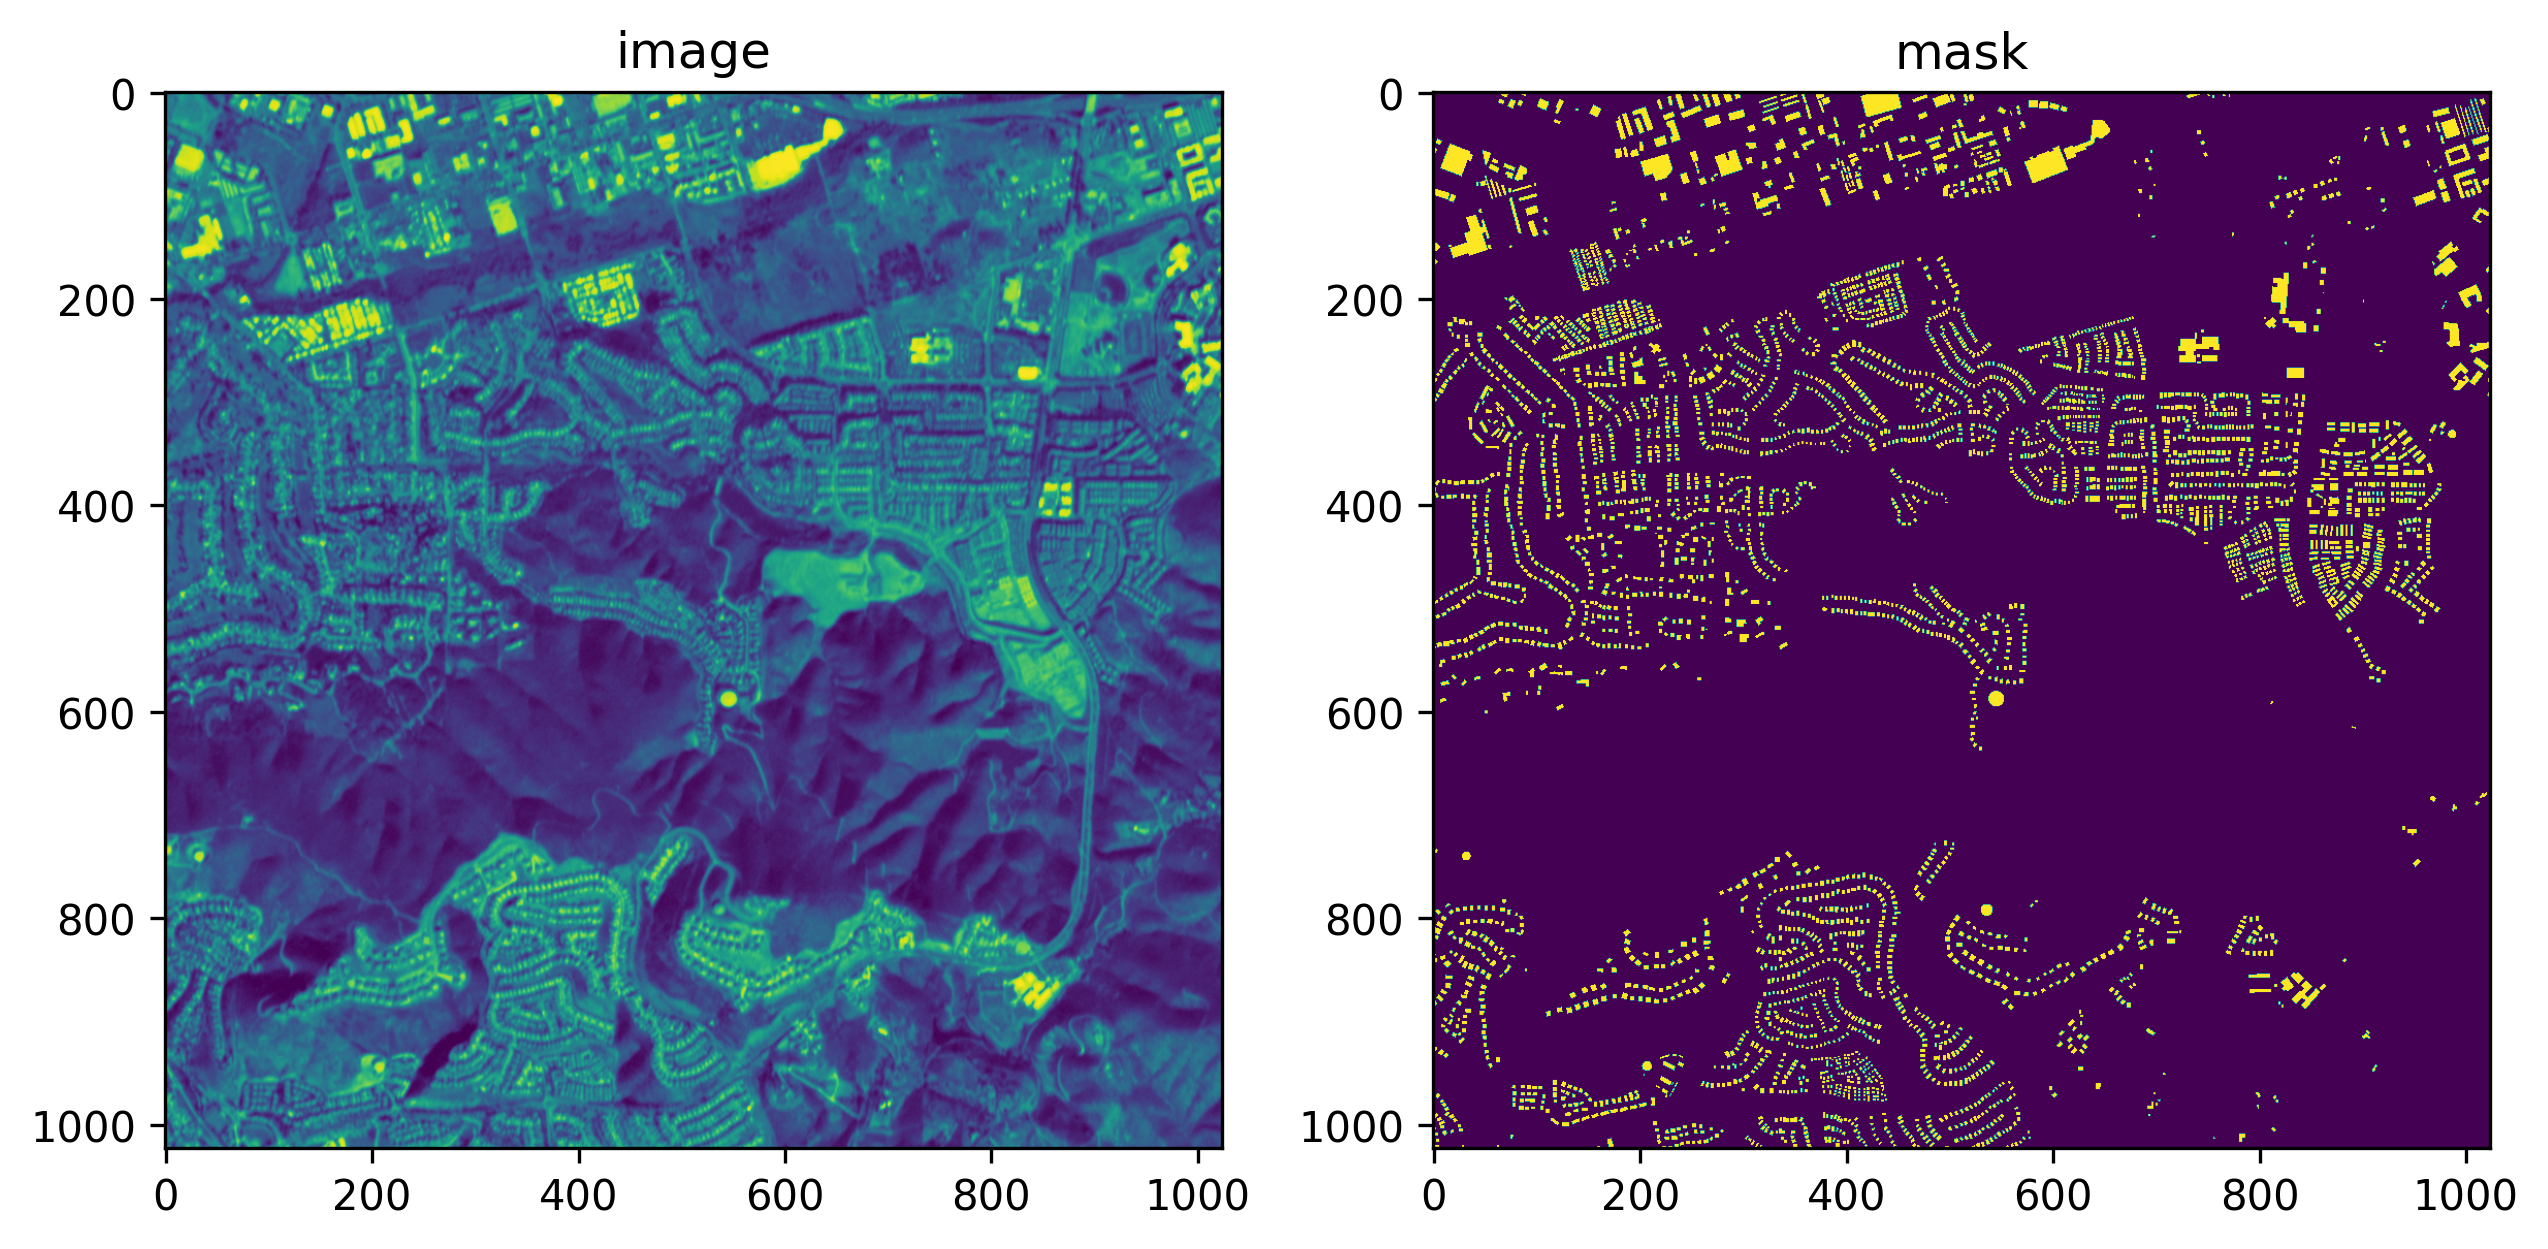

In [9]:
sample = train_set[10]

raster_diff = sample['raster_diff']

mask_diff = sample['mask_diff']


print(f"raster_diff: {raster_diff.shape} - mask_diff: {mask_diff.shape}")
images = [raster_diff[1,:,:].squeeze(),mask_diff.squeeze()]

mpl.rcParams['figure.dpi'] = 300
_,axs = plt.subplots(1,2,figsize=(10,10))

titles = ['image','mask']

for i,ax in enumerate(axs):
    ax.set_title(titles[i])
    ax.imshow(images[i]);

In [10]:
# Testing if images are correct
test_raster_path = Path(os.path.join("../../DATASET/dataset_pruebas/train/",train_set.annotations.images[0]))
test_gdf = gpd.read_file(os.path.join("../../DATASET/dataset_pruebas/train/",train_set.annotations.labels_match_pix[0]))

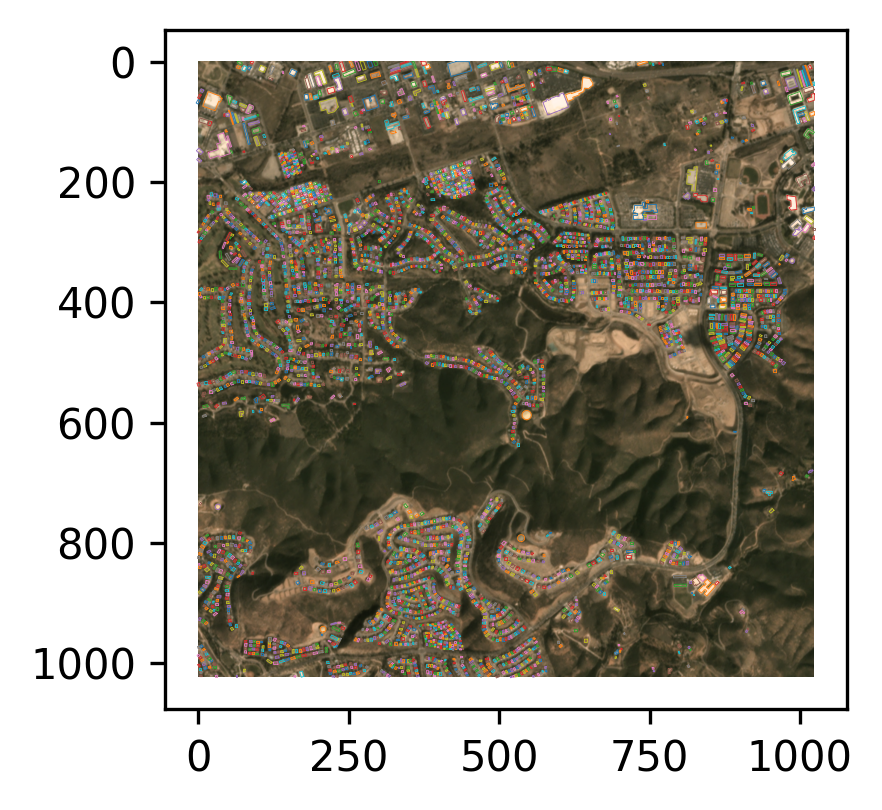

In [11]:
def plot_gdf(gdf,fill=False,ax=None,linewidth=0.2):
    if ax is None:
        _,ax = plt.subplots(1,figsize=(3, 3))
        
    for geom in gdf['geometry']:
        if fill:
            patch = PolygonPatch(geom,linewidth=linewidth,color='fuchsia')
            ax.add_patch(patch)
        else:
            ax.plot(*geom.exterior.xy,linewidth=linewidth)
    return(ax)
def plot_sat(path,gdf=None, fill=False,linewidth=0.2):
    f, ax = plt.subplots(1,figsize=(3, 3))
    f.tight_layout()
    
    r = rio.open(path)
    r = r.read()
    r = r.transpose((1,2,0,))
    ax.imshow(r)
    
    if gdf is not None:
        plot_gdf(gdf,fill=fill,ax=ax,linewidth=linewidth)
        
    return(ax)

plot_sat(path=test_raster_path,gdf=test_gdf);

## [Data Augmentation](https://github.com/albumentations-team/albumentations)



In [12]:
!pip install -U albumentations --user

In [13]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        raster_diff, mask_diff = sample['raster_diff'], sample['mask_diff']
        sample['raster_diff'] = torch.from_numpy(raster_diff)
        sample['mask_diff'] = torch.from_numpy(mask_diff)
        
        return sample
        
class AsImage(object):
    """Convert shape of image from (Channels,Rows,Columns) to (Rows,Column,Channels)."""

    def __call__(self, sample):
        raster_diff, mask_diff = sample['raster_diff'], sample['mask_diff']
        sample['raster_diff'] = torch.from_numpy(raster_diff)
        sample['mask_diff'] = torch.from_numpy(mask_diff)
        
        return sample

In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
A.Rotate(limit=(-360, 360), interpolation=4, border_mode=4,p=0),

(Rotate(always_apply=False, p=0, limit=(-360, 360), interpolation=4, border_mode=4, value=None, mask_value=None),)

In [15]:
chip_dimension = 256

transform = A.Compose(
    [
        A.PadIfNeeded(min_height=chip_dimension,min_width=chip_dimension,value=0,p=2),
        A.RandomRotate90(p=1.0),
        ToTensorV2()
    ]
)

In [16]:
train_set_augmented = Dataloader_trdp(root_dir=root_dir,csv_file=csv_file,chip_dimension=chip_dimension,transform=transform)

In [17]:
for i in range(len(train_set_augmented)):
    sample = train_set[i]
    # verify dimensionality
    print(sample['raster_diff'].shape, sample['mask_diff'].shape)
    if i==15:
        break

(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
(3, 1023, 1024) (1, 1023, 1024)
